In [1]:
# Handout: https://andrewcumming.github.io/phys512/hw1.html

import numpy as np
import matplotlib.pyplot as plt

## 1) Roundoff error in long term integrations of planetary orbits

In [2]:
GM = 1.3271e20 # m^3 s^-2
AU = 1.496e11 # m
yr = 365*24*3600 # s

def E(x,v): # Energy per unit mass
    return -GM/np.sqrt(x[0]**2 + x[1]**2) + 0.5*(v[0]**2 + v[1]**2)

def run(dt):
    
    N = int(yr/dt)
    X = np.zeros((N,2))
    V = np.zeros((N,2))
    
    X[0] = [AU, 0]
    V[0] = [0, np.sqrt(GM/AU)]
    E0 = E(X[0],V[0])

    for i in range(1,N):

        x,v = X[i-1],V[i-1]
        r = np.sqrt(x[0]**2 + x[1]**2)
        a = -GM/r**2 * x/r
             
        V[i] = v + a*dt
        # X[i] = x + v*dt # explicit euler
        X[i] = x + V[i]*dt # semi-implicit euler
        
    err = abs((E(X[-1],V[-1]) - E0)/E0)
    return X, err

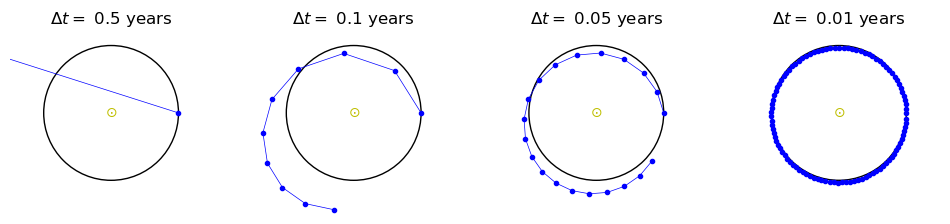

In [3]:
# Testing our integrator, showing 1 year orbit
fig,axes = plt.subplots(1, 4, figsize=(12,3))
for dt_yr,ax in zip((0.5,0.1,0.05,0.01), axes):
    X,_ = run(dt_yr*yr)
    ax.axis("off")
    ax.plot(X[:,0]/AU, X[:,1]/AU, 'b.-', lw=0.5)
    c = plt.Circle((0, 0), 1.0, color='k', lw=1.0, fill=False)
    ax.add_patch(c)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    ax.set_aspect('equal', 'box')
    ax.set_title(fr"$\Delta t=$ {dt_yr} years", y=0.9)
    ax.text(0,0,r"$\odot$",ha="center",va="center",color="y")
plt.show()

In [4]:
# Scaling on the energy error
# This takes a bit of time

# simpler algorithm which does not store the positions and velocities 
# it is ~5x faster
def run(dt):
    x,y = AU, 0
    vx,vy = 0, np.sqrt(GM/AU)
    E0 = E([x,y], [vx,vy])
    for _ in range(int(yr/dt)):
        r2 = x**2 + y**2
        vx -= GM*x/r2**(3/2) * dt
        vy -= GM*y/r2**(3/2) * dt
        x += vx*dt
        y += vy*dt
    return abs((E([x,y],[vx,vy]) - E0)/E0)

import time
Dt = np.logspace(-1, -7, 7)
errs = []
for dt in Dt:
    t0 = time.time()
    errs.append(run(dt*yr))
    print(f"dt/yr {dt:.1e}  done in {time.time()-t0:.1e} s")

dt/yr 1.0e-01  done in 7.8e-05 s
dt/yr 1.0e-02  done in 2.4e-04 s
dt/yr 1.0e-03  done in 1.5e-03 s
dt/yr 1.0e-04  done in 1.6e-02 s
dt/yr 1.0e-05  done in 1.2e-01 s
dt/yr 1.0e-06  done in 1.1e+00 s
dt/yr 1.0e-07  done in 1.1e+01 s


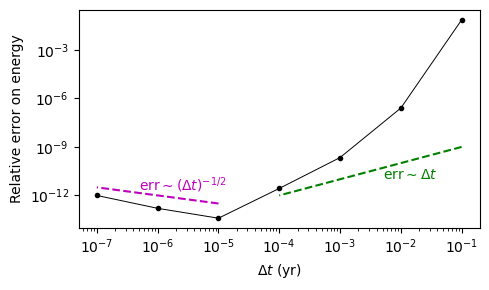

In [5]:
plt.figure(figsize=(5,3))
plt.xlabel(r"$\Delta t$ (yr)")
plt.ylabel(r"Relative error on energy")
plt.loglog(Dt, errs, 'k.-', lw=0.7)

# Semi-implicit is first order accurate, so should have error ~ dt scaling
# for timesteps where roundoff does not matter
# Just need to tweak the constant prefactor so that the line shows up on the plot
plt.loglog(Dt[:4], 1e-8*Dt[:4], 'g--')
plt.text(5e-3,1e-11,r"err$\sim\Delta t$", color="g")

# Brouwer's scaling says error ~ sqrt(N) ~ 1/sqrt(dt)
plt.loglog(Dt[4:], 1e-15/np.sqrt(Dt[4:]), 'm--')
plt.text(5e-7,2e-12,r"err$\sim(\Delta t)^{-1/2}$", color="m")

plt.tight_layout()
plt.show()

## 2) Interpolation and thermodynamics

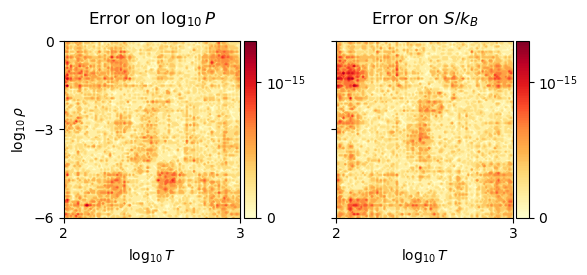

In [6]:
mu = 1.66e-27
hbar = 1.056e-34

def logP(logT, logRho):
#     return np.log10(k) + logRho + logT - np.log10(28*mu)
    return logRho + logT - np.log10(28*mu) # k=1 units

def S(logT, logRho):
    n = 10**logRho/(28*mu)
    nq = (28*mu*10**logT/(2*np.pi*hbar**2))**(3/2)
    return 5/2 - np.log(n/nq) # k=1 units

# Interpolate
from scipy.interpolate import RectBivariateSpline as RBS

# Coarse grid for interpolation
xp = np.linspace(2, 3, 10) # logT
yp = np.linspace(-6, 0, 10) # logRho
X,Y = np.meshgrid(xp, yp, indexing="ij")

interp_logP = RBS(xp, yp, logP(X, Y))
interp_S    = RBS(xp, yp, S(X, Y))

# Finer grid
xx = np.linspace(2, 3, 100)
yy = np.linspace(-6, 0, 100)
X,Y = np.meshgrid(xx, yy, indexing="ij")

# Plot
# see https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_grid.html

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(6,3))

grid = ImageGrid(
    fig, 111,  
    nrows_ncols=(1, 2), axes_pad=0.8, label_mode="L", share_all=True,
    cbar_location="right", cbar_mode="each", cbar_size="7%", cbar_pad="2%")

for ax, cax, Z in zip(grid, grid.cbar_axes,
                     ((interp_logP(X, Y, grid=False) - logP(X, Y))/logP(X, Y),
                     (interp_S(X, Y, grid=False) - S(X, Y))/S(X, Y))
                     ):
    im = ax.contourf(X, Y, np.abs(Z)/1e-15, levels=np.linspace(0,1.3,100), cmap="YlOrRd")
    cax.colorbar(im)
    ax.set_aspect(1.0/ax.get_data_ratio())
    ax.set_xlabel(r"$\log_{10} T$")
    cax.set_yticks([0,1],["0","$10^{-15}$"])
    
grid.axes_llc.set_xticks([2,3])
grid.axes_llc.set_yticks([-6,-3,0])

grid[0].set_ylabel(r"$\log_{10} \rho$")
grid[0].set_title(r"Error on $\log_{10} P$", y=1.05)
grid[1].set_title(r"Error on $S/k_B$", y=1.05)

plt.show()

For the next part, note that we can re-write
$$-\frac{\partial S}{\partial n}\bigg|_T = \frac{1}{n^2}\frac{\partial P}{\partial T}\bigg|_n\,,$$
as
$$\frac{-1}{\ln 10}\frac{\partial S}{\partial \log_{10}\rho}\bigg|_T = \frac{P}{nT}\frac{\partial \log_{10}P}{\partial \log_{10}T}\bigg|_\rho$$

Both sides should obviously evaluate to 1 (in $k_B=1$ units).

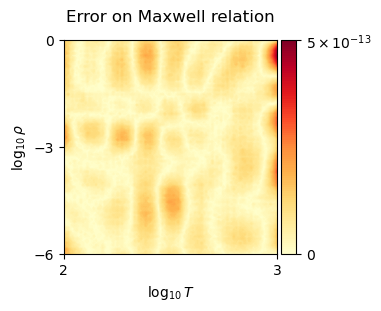

In [7]:
# Partial derivatives
dS_dlogRho = interp_S.partial_derivative(0,1)
dlogP_dlogT = interp_logP.partial_derivative(1,0)

# Evaluate both sides of the equation
LHS = -dS_dlogRho(X, Y, grid=False)/np.log(10)
RHS = 10**interp_logP(X, Y, grid=False)*28*mu/10**(X+Y) * dlogP_dlogT(X, Y, grid=False)

fig = plt.figure(figsize=(3,3))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1),
    cbar_location="right", cbar_mode="each", cbar_size="7%", cbar_pad="2%")
ax = grid[0]
im = ax.contourf(X, Y, np.abs(LHS-RHS)/LHS/1e-13, levels=np.linspace(0,5,100), cmap="YlOrRd")
cax = grid.cbar_axes[0]
cax.colorbar(im)
ax.set_aspect(1.0/ax.get_data_ratio())
ax.set_xlabel(r"$\log_{10} T$")
cax.set_yticks([0,5],["0",r"$5\times 10^{-13}$"])
    
ax.set_xticks([2,3])
ax.set_yticks([-6,-3,0])

ax.set_ylabel(r"$\log_{10} \rho$")
ax.set_title(r"Error on Maxwell relation", y=1.05)

plt.show()